# Energy Likelihood
This code is eventually folded into the IceCubeAnalysis file so that I can run it in the likelihood function, but I first tested out the likelihood here to make sure it was working correctly, so I figured I would add this as well. 

In [45]:
import glob
import scipy.interpolate
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load up the background and signal neutrino data

In [46]:
background_data = np.load("./processed_data/background_energies_muon.npz",
                       allow_pickle=True)



background_ra = np.array(background_data["data_ra"])
background_eng = np.array(background_data["data_eng"])
background_dec = np.array(background_data["data_dec"])

In [47]:
signal_data = np.load("./processed_data/signal_energies_muon.npz",
                       allow_pickle=True)
signal_ra = np.array(signal_data["data_ra"])
signal_eng = np.array(signal_data["data_eng"])
signal_dec = np.array(signal_data["data_dec"])



Here I load and plot the energies of the signal and background data dependent on sky to create a probability function.  

9174
23441


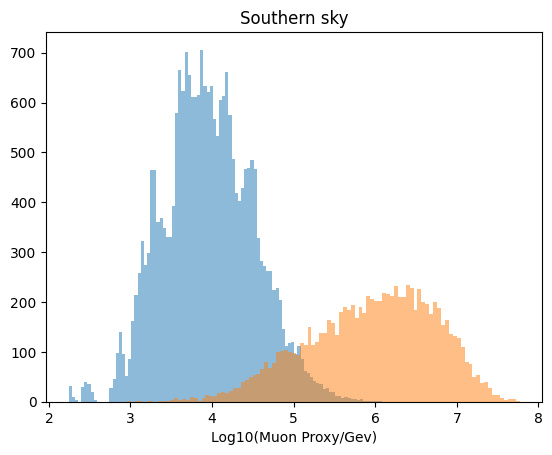

6670
16741


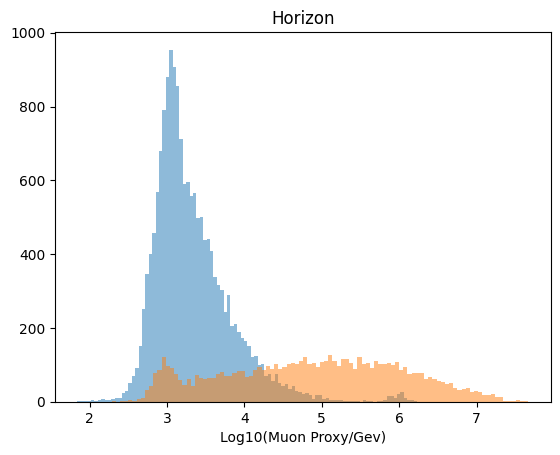

12385
31589


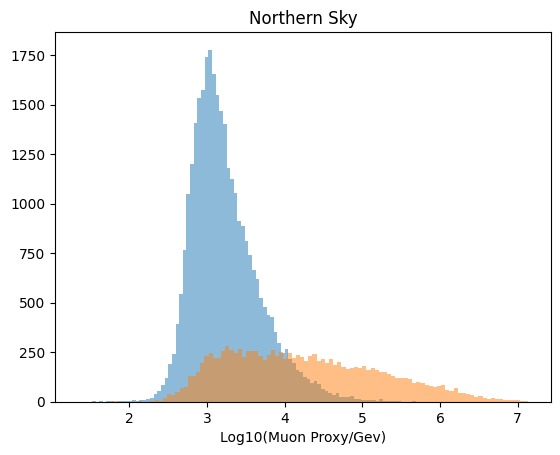

In [51]:
background_bins = np.zeros((3,100))
background_energies = np.zeros((3,100))
signal_bins = np.zeros((3,100))
signal_energies = np.zeros((3,100))
labels = ["Southern sky", "Horizon","Northern Sky"]
background_args = [background_dec<-10, np.logical_and(background_dec>=-10, background_dec<10),background_dec>=10]
signal_args = [signal_dec<-10, np.logical_and(signal_dec>=-10, signal_dec<10),signal_dec>=10]



allowed = signal_dec<-10

for i in range(3):
    background_bins[i], background_lims, patches = plt.hist(background_eng[background_args[i]],alpha=0.5, bins=100)
    signal_bins[i], signal_lims, patches = plt.hist(signal_eng[signal_args[i]],alpha=0.5,bins=100)
    print(len(signal_eng[signal_args[i]]))
    print(len(background_eng[background_args[i]]))
    plt.title(labels[i])
    plt.xlabel("Log10(Muon Proxy/Gev)")
    plt.show()
    
    for k in range(len(background_bins[i])):
        background_energies[i][k] = (background_lims[k] + background_lims[k+1])/2
        signal_energies[i][k] = (signal_lims[k]+signal_lims[k+1])/2
        
        

Here is where I make the probability function, then I make some plots that helped me realize where the function went wrong. 

1.0
1.0


/var/folders/p7/rnqz4ghn3cvdr6kztyk93px40000gn/T/ipykernel_51330/2433991524.py:32: RuntimeWarning: invalid value encountered in divide
  energy_prob[i] = number_signal / (number_background+number_signal)


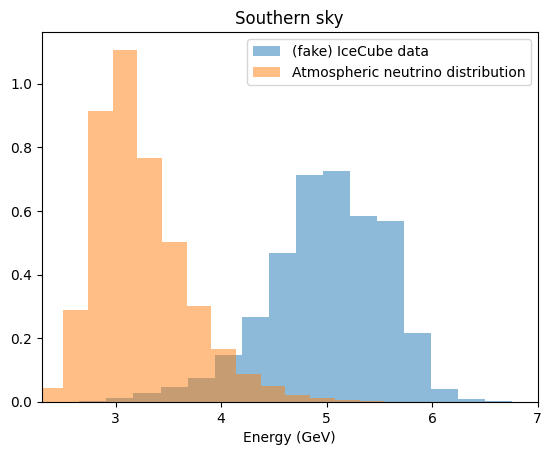

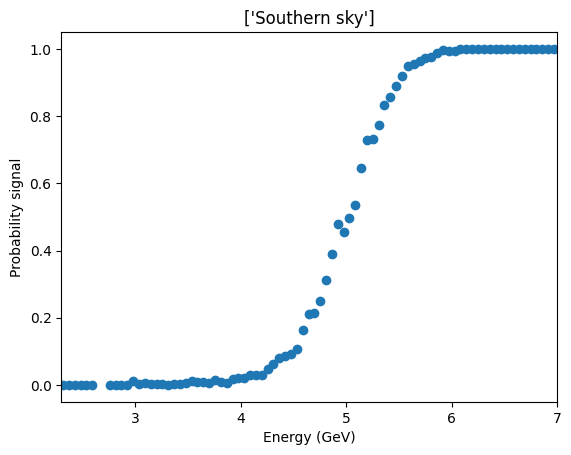

324315
1.0
1.0


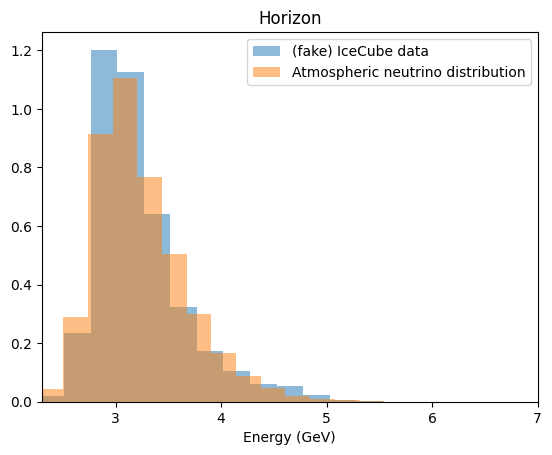

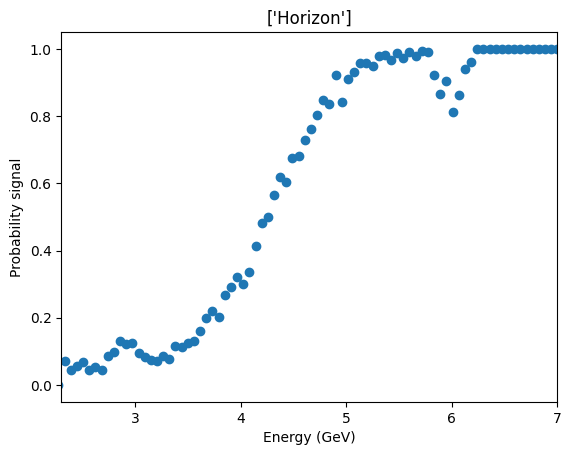

237265
1.0
5.0


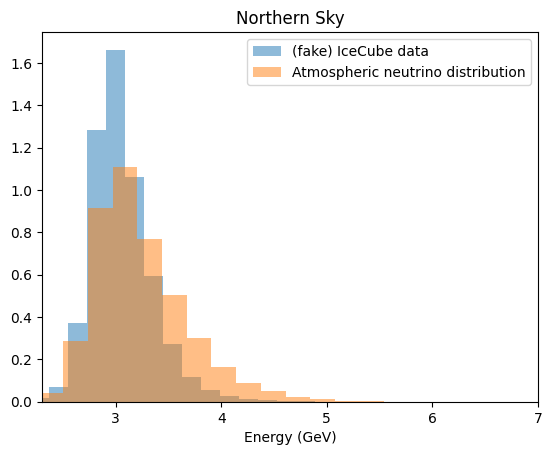

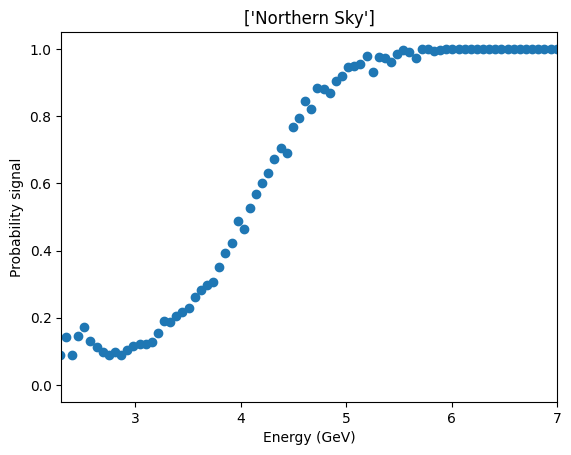

438420


In [52]:
energies = np.zeros((3,100))
energy_prob = np.zeros((3,100))
background_fill = [[30,0],[2,4],[1,0]]
signal_fill = [[1,0],[1,0],[2,10]]
icecube_data = np.load("./processed_data/output_icecube_data_fake.npz",
                       allow_pickle=True)

data_sigmas = np.array(icecube_data["data_sigmas"])
allowed_entries = data_sigmas != 0
data_dec = np.array(icecube_data["data_dec"])
data_eng = np.array(icecube_data["data_eng"])

data_dec = data_dec[allowed_entries]
data_eng = data_eng[allowed_entries]


data_prob = np.zeros(len(data_eng))
dec_args =[data_dec<-10, np.logical_and(data_dec>=-10, data_dec<10),data_dec>=10]
for i in range(3):
    f_background = scipy.interpolate.interp1d(background_energies[i], background_bins[i],bounds_error=False, fill_value=0)
    f_signal = scipy.interpolate.interp1d(signal_energies[i], signal_bins[i],bounds_error=False, fill_value=0)
    
    print(background_bins[i][99])
    print(signal_bins[i][99])
    
    energies[i] = np.linspace(np.min(background_energies[i]),np.max(signal_energies[i]),100)    
    
    number_background = f_background(energies[i])
    number_signal = f_signal(energies[i])
    
    
    energy_prob[i] = number_signal / (number_background+number_signal)
    plt.hist(data_eng[dec_args[i]], bins=20, density = True, label = "(fake) IceCube data", alpha = 0.5)
    plt.xlabel("Energy (GeV)")
    plt.hist(background_eng[background_dec>10], bins = 20, density = True, label = "Atmospheric neutrino distribution", alpha = 0.5)
    plt.xlim(2.3,7)
    plt.title(labels[i])
    plt.legend()
    plt.show()
    plt.scatter(energies[i], energy_prob[i])
    plt.xlim(2.3,7)
    plt.title([labels[i]])
    plt.xlabel("Energy (GeV)")
    plt.ylabel("Probability signal")
    plt.show()
    print(len(data_eng[dec_args[i]]))

In [50]:
np.savez("./processed_data/energy_likelihood.npz",
        data_eng = energies[1],
        energy_prob_north = energy_prob[2],
        energy_prob_hor = energy_prob[1])
